# Detecting Twitter moments that have significant impact on a public sentiment

## Collecting the data

We use [Twitterscraper](https://github.com/taspinar/twitterscraper) to collect tweets that mention our celebrity figures of note.

In [ ]:
from datetime import datetime, date, timedelta

import json

import sys

from twitterscraper import query_tweets

def datetime_handler(x):
    if isinstance(x, dt.datetime):
        return x.isoformat()
    raise TypeError('Unknown type')

def collect_tweets(name, articleDate):
    name = name.lower()

    articleDate = datetime.strptime(articleDate, '%m/%d/%y')
    beginDate = (articleDate - timedelta(days=90)).date()
    endDate = (articleDate + timedelta(days=90)).date()

    # Collect tweets with mentions in the form of "FirstName LastName"
    tweets = query_tweets(name, limit=None, begindate=beginDate, enddate=endDate, poolsize=40, lang='en')
    tweets_serialized_pt1 = [tweet.__dict__ for tweet in tweets]

    # Collect tweets with mentions in the form of "FirstNameLastName"
    no_space_name = name.replace(' ', '')

    tweets = query.query_tweets(no_space_name, limit=None, begindate=beginDate, enddate=endDate, poolsize=40, lang='en')
    tweets_serialized_pt2 = [tweet.__dict__ for tweet in tweets]

    tweets_serialized = tweets_serialized_pt1 + tweets_serialized_pt2

    with open(outfile_str, 'w') as outfile:
        json.dump(tweets_serialized, outfile, default=datetime_handler)
        print('tweets saved!')

In [ ]:
name = input("Name (FirstName LastName): ")
articleDate = input("Article date (mm/dd/yy): ")

print('Collecting tweets for ' + name)
print('Article release ~ ' + articleDate + '\n')

collect_tweets(name, articleDate)

## Pre-processing the data for sentiment analysis

In [ ]:
import pandas as pd

from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank

import sys

from multiprocessing import cpu_count, Pool

from tqdm import tqdm

tokenizer = treebank.TreebankWordTokenizer()

def get_lexicon_polarity(row):
    # Possible improvements: Make entity-based; consider lexicon in context
    polarity = 'NaN'
    pos_words = 0
    neg_words = 0

    tokenized_sent = [word.lower() for word in tokenizer.tokenize(row['text'])]

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
        elif word in opinion_lexicon.negative():
            neg_words += 1

    if pos_words > neg_words:
        polarity = 'positive'
    elif pos_words < neg_words:
        polarity = 'negative'
    elif pos_words == neg_words:
        polarity = 'neutral'

    # print(row['text'] + ': ' + polarity)

    return polarity

def process_data(func, df, num_processes=None):
    if num_processes == None:
        num_processes = min(df.shape[0], cpu_count())

    with Pool(processes = num_processes) as pool:
        seq = []

        for index, row in df.iterrows():
            seq.append(row)

        results_list = list(tqdm(pool.imap(get_lexicon_polarity, seq), total=len(df.index)))

        df['lex_polarity'] = results_list

In [ ]:
name = input('Name of .json file: ')

infile = name + '.json'
outfile = name + '_lex_pol.json'

print('reading from ' + infile)

corpus = pd.read_json(infile)

print('identifying sentiments...')
process_data(get_lexicon_polarity, corpus, num_processes=cpu_count())

print('saving to ' + outfile)
corpus.to_json(path_or_buf=outfile)

## Visualizing sentiment over time

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

/Users/ttle/anaconda/envs/undergradHonors/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
tweets = pd.read_json('dan_harmon_lex_pol.json')
tweets.sort_values(by='timestamp', inplace=True)
startDate = date(2017, 12, 15)
endDate = date(2018, 2, 15)

tweets['timestamp'] = pd.to_datetime(tweets['timestamp']).apply(lambda x: x.date())

tweets_stub = tweets[tweets['timestamp'] >= startDate]
tweets_stub = tweets_stub[tweets_stub['timestamp'] <= endDate]
tweets_stub.sort_values(by='timestamp', inplace=True)

df = tweets_stub.groupby(['timestamp', 'lex_polarity']).size()
df = df.reset_index()
df.columns = ['timestamp', 'polarity', 'size']

Text(0,0.5,'Number of Tweets')

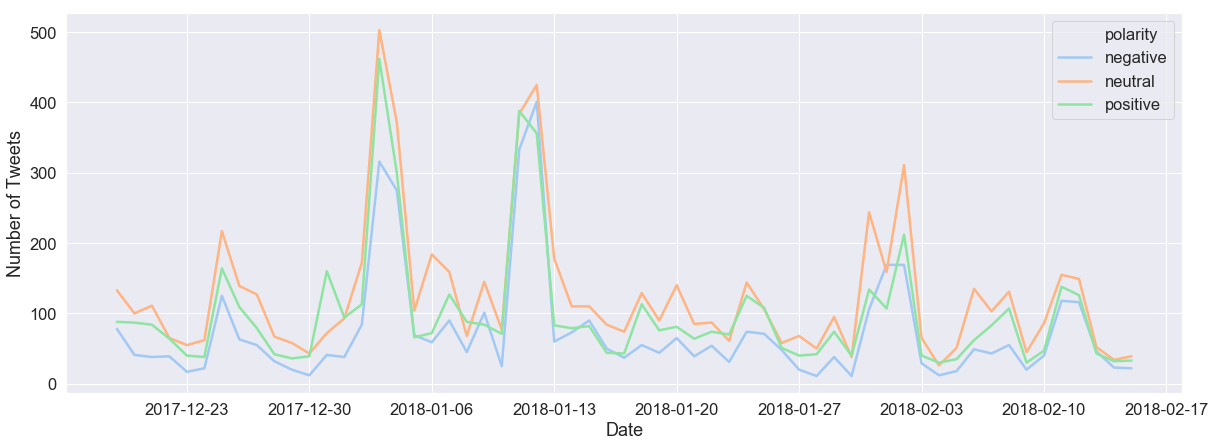

In [5]:
dims = (20, 7)
fig, ax = plt.subplots(figsize=dims)

ax = sns.lineplot(ax = ax, x='timestamp', y='size', hue='polarity', palette='pastel', data=df)
ax.set_xlabel("Date")
ax.set_ylabel("Number of Tweets")

In [12]:
from wordcloud import WordCloud, STOPWORDS
import re
import string

In [21]:
# the regex used to detect words is a combination of normal words, ascii art, and emojis
# 2+ consecutive letters (also include apostrophes), e.x It's
normal_word = r"(?:\w[\w']+)"
# 2+ consecutive punctuations, e.x. :)
ascii_art = r"(?:[{punctuation}][{punctuation}]+)".format(punctuation=string.punctuation)
# a single character that is not alpha_numeric or other ascii printable
emoji = r"(?:[^\s])(?<![\w{ascii_printable}])".format(ascii_printable=string.printable)
regexp = r"{normal_word}|{ascii_art}|{emoji}".format(normal_word=normal_word, ascii_art=ascii_art,
                                                     emoji=emoji)


words = ' '.join(tweets['text'])
# remove links
clean_text = re.sub(r'http\S+', '', words)

wordcloud = WordCloud(max_words=500, scale=3, background_color='white', regexp=regexp).generate(clean_text)

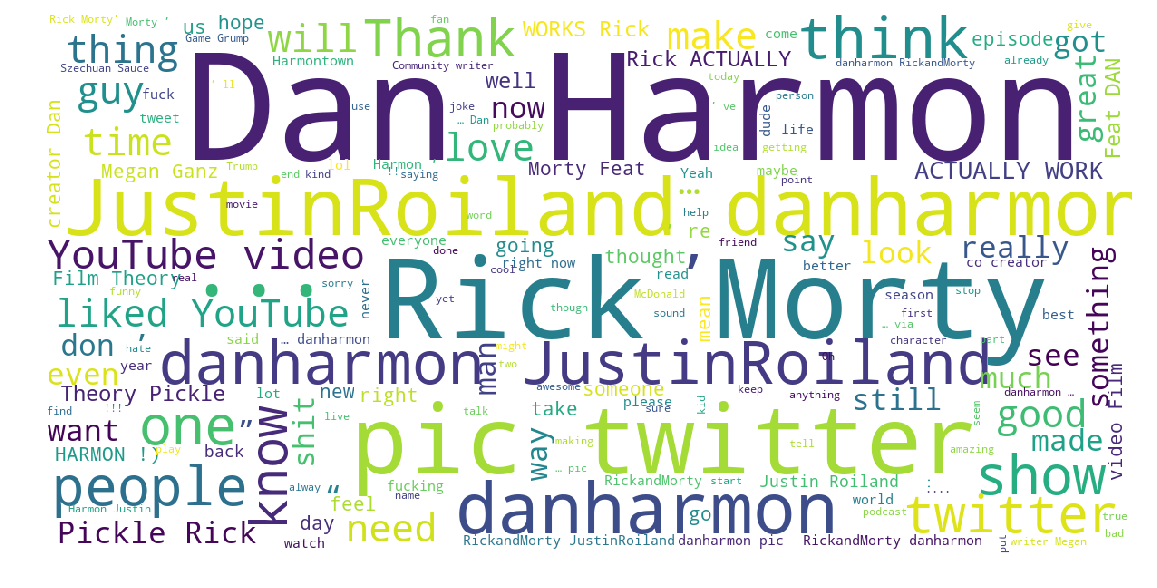

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file('dan_harmon_cloud.png')

Check out this website to do word to frequency
https://github.com/Mantej-Singh/Word-Frequency---Python/blob/master/Word%20Frequency.ipynb

# Follow links given in tweets

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import json
import sys
import string
from urllib.request import urlopen
from urllib.error import URLError, HTTPError

from tqdm import tqdm

import pandas as pd
from bs4 import BeautifulSoup
from bs4.element import Comment

from multiprocessing import cpu_count, Pool

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

def page_scrape(tuple):
    uid, link = tuple

    link_clean = link.translate(translator)

    if (link_clean.find('youtube') == -1 and link_clean.find('twitter') == -1
            and link_clean.find('facebook') == -1):
        try:
            html_page = urlopen(link)
            body = text_from_html(html_page)
            if (len(body) > 0):
                return (uid, link, body)
        except HTTPError as e:
            print('The server couldn\'t fulfill the request.')
            print('Error code: ', e.code)
        except URLError as e:
            print('We failed to reach a server.')
            print('Reason: ', e.reason)
        except:
            print("Unexpected error:", sys.exc_info()[0])

if __name__ == '__main__':
    infile = sys.argv[1] + '.csv'
    outfile = sys.argv[1] + '_linkbodytext.json'

    df = pd.read_csv(infile)
    
    links = dict(zip(df.id, df.URL))
    
    # This uses the 3-argument version of str.maketrans
    # with arguments (x, y, z) where 'x' and 'y'
    # must be equal-length strings and characters in 'x'
    # are replaced by characters in 'y'. 'z'
    # is a string (string.punctuation here)
    # where each character in the string is mapped
    # to None
    translator = str.maketrans('', '', string.punctuation)

    with Pool(processes = cpu_count()) as pool:
        results = list(tqdm(pool.imap(page_scrape, links.items()), total=len(links.items())))
    
    with open(outfile, 'w') as fp:
        json.dump(results, fp)

# Tag body text of links with sentiment